## Лабораторная работа 1

#### Явная и неявная ***конечно-разностные схемы***, схема Кранка-Николсона. Решение начально краевых задач для уравнений **параболического** типа.

вариант 4

dU / dt = a * d2U / dx2 ; a > 0

U_x(0,t) = exp(-at)

U_x(pi,t) = -exp(-at)

U(x,0) = sin(x)

Аналитическое решение U(x,t) = exp(-at) * sin(x)

In [1]:
from math import pi, sin, exp, log
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Гиперкласс для основных методов

In [2]:
class Data:
    def __init__(self, t_max = 1, x_max = pi, x=10, t=7, a=2):
        self.x_diap = np.linspace(0, x_max, endpoint=True, num=x)
        self.t_diap = np.linspace(0, t_max, endpoint=True, num=t)
        self.x = x
        self.t = t
        self.a = a # данный гиперпараметр можно менять (коэф теплопроводности)
        self.l_x = [exp(-self.a * i) for i in self.t_diap] # значение левой производной на всем интервале времени
        self.r_x = [-exp(-self.a * i) for i in self.t_diap] # значение правой производной на всем интервале времени
        assert len(self.l_x) == len(self.t_diap)
        self.q = ((t_max - 0) / t) / ((x_max - 0) / x)**2 # dt / dx^2
        self.dt = (t_max - 0) / t
        self.dx = (x_max - 0) / x
        # считаем начальную матрицу первую строчку заполняем начальными условиями остальное None
        self.U = [[sin(self.x_diap[i]) for i in range(self.x)]] + [[None for i in range(self.x)] for j in range(self.t-1)]
    def d(self): # показывает матрицу U
        df = pd.DataFrame(np.array(self.U), columns=self.x_diap, index=self.t_diap)
        print(df, df.shape)
    def display(self, title): # показывает получившийся + правильный графики решения
        fig, axs = plt.subplots(1, 2,figsize=(20,6))
        fig.suptitle(title)
        for i, row in enumerate(self.U):
            axs[0].plot(row, label="t={:.3f}".format(self.t_diap[i]))
        for t in self.t_diap:
            axs[1].plot([exp(-self.a * t) * sin(x) for x in self.x_diap])
        fig.legend()
    def error(self, steps):
        plt.figure(figsize=(20, 6))
        plt.suptitle('Ошибка в зависимости от шага')
        for j in [5,7,10,15,25,35]:
            errA = []
            for i in steps[::-1]:
                d = CrankNicolson(x=i, t_max=j, t=20)
                real = [exp(-self.a * self.t_diap[::-1][0]) * sin(x) for x in d.x_diap]
                d.fit()
                errA.append(sum([abs(real[j] - d.U[::-1][0][j])**2 for j in range(len(real))])**0.5)
            plt.plot(steps, errA, label=f"t={j}")
        plt.legend()

### Метод прогонки

In [3]:
def solveTD(m, b):
    y = [None] * len(m)
    alpha = [None] * len(m)
    beta = [None] * len(m)
    for i in range(len(m)):
        if i == 0:
            y[i] = m[i][0]
            alpha[i] = -1 * m[i][1] / y[i]
            beta[i] = b[i] / y[i]
        elif i == len(m) - 1:
            y[i] = m[i][1] + m[i][0] * alpha[i-1]
            beta[i] = (b[i] - m[i][0] * beta[i-1]) / y[i]
        else:
            y[i] = m[i][1] + m[i][0] * alpha[i-1]
            alpha[i] = -1 * m[i][2] / y[i]
            beta[i] = (b[i] - m[i][0] * beta[i-1]) / y[i]
    x = [0] * len(m)
    for i in range(len(m)):
        if i == 0:
            x[len(m)-i-1] = beta[len(m)-i-1]
        else:
            x[len(m)-i-1] = alpha[len(m)-i-1] * x[len(m)-i] + beta[len(m)-i-1]
    return x

### Явная конечно-разностная схема

In [4]:
class ExplicitScheme(Data):
    def fit(self, method = "3 dots"): # может быть 2 dots или 3 dots для разных апроксимаций второй производной
        for i in range(1, self.t):
            if method == "3 dots":
                solve = [self.U[i-1][j] + self.a * self.q * (self.U[i-1][j+1] - 2 * self.U[i-1][j] + self.U[i-1][j-1]) for j in range(1, self.x - 1)]
                solve = [0] + solve + [0]
            elif method == "2 dots":
                solve = [0] + [self.U[i-1][j] + self.a * (self.dt / (2 * self.dx)) * (self.U[i-1][j+1] - self.U[i-1][j-1]) for j in range(1, self.x - 1)] + [0]
            for idx, item in enumerate(solve):
                self.U[i][idx] = item

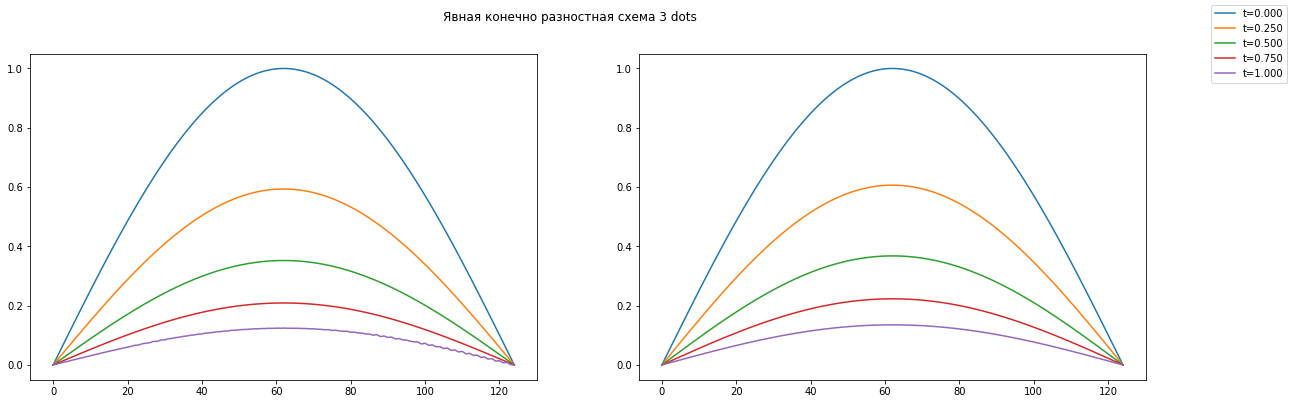

In [6]:
data = ExplicitScheme(x=125, t=5)
data.fit("3 dots")
# data.d()
data.display('Явная конечно разностная схема 3 dots')
# data.error(np.arange(5,150))

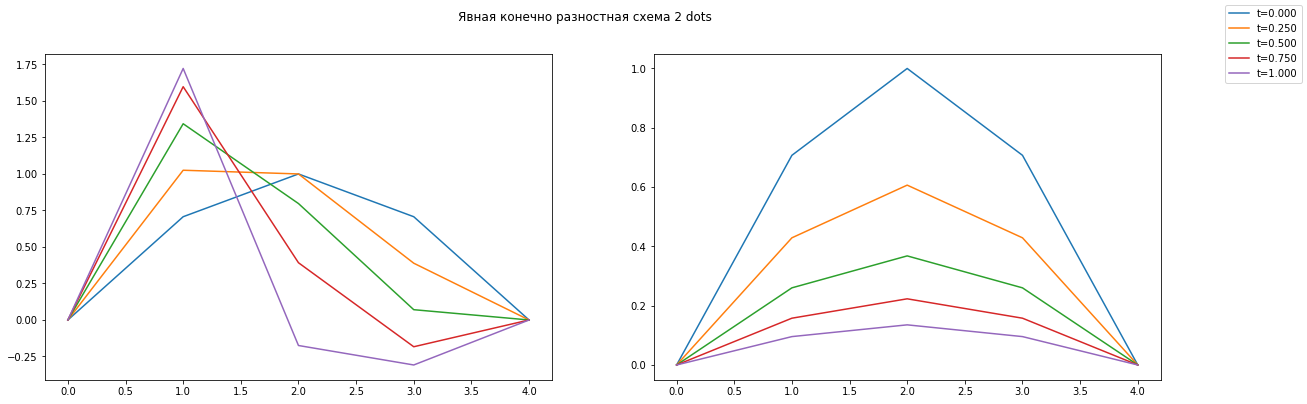

In [8]:
data = ExplicitScheme(x=5, t=5)
data.fit("2 dots")
# data.d()
data.display('Явная конечно разностная схема 2 dots')
# data.error(np.arange(5,150))

### Неявная конечно-разностная схема

In [9]:
class NonExplicitScheme(Data):
    def fit(self, method = "3 dots"): # может быть 2 dots или 3 dots для разных апроксимаций второй производной
        # составляем трехдиагональную матрицу решаем получаем новые значения температур, вписываем их в матрицу
        for i in range(1, self.t):
#             M = [[1,0]] + [[-self.q * 0.5 * self.a, 1 + self.q * self.a, -self.q * 0.5 * self.a] for i in range(1, self.x - 1)] + [[0,1]]
            M = [[1 + self.q * self.a, 0]] + \
                [[-self.q * 0.5 * self.a, 1 + self.q * self.a, -self.q * 0.5 * self.a] for i in range(1, self.x - 1)] + \
                [[0,1]]
            B = [0] + \
            [self.U[i-1][j] for j in range(1, self.x - 1)] \
            + [0]
            for idx,item in enumerate(solveTD(M,B)):
                self.U[i][idx] = item

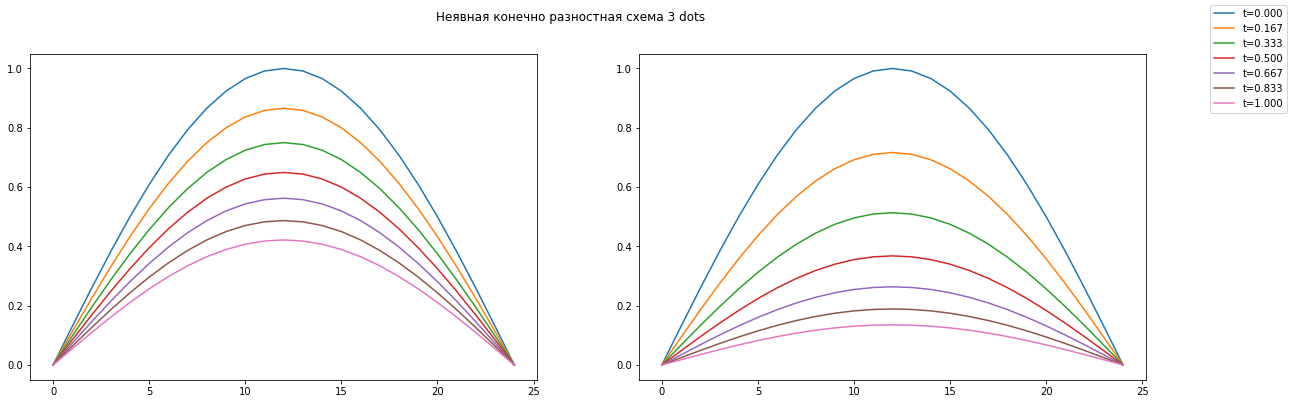

In [12]:
data = NonExplicitScheme(x=25)
data.fit("3 dots")
# data.d()
data.display('Неявная конечно разностная схема 3 dots')
# data.error(np.arange(5,150))

In [13]:
# data = NonExplicitScheme(x=725)
# data.fit("2 dots")
# data.d()
# data.display('Неявная конечно разностная схема 2 dots')
# data.error(np.arange(5,150))

### Метод Кранка – Николсона

In [14]:
class CrankNicolson(Data):
    def fit(self): # из основной функции выражаем след по времени переменные через текущие известные
        # составляем трехдиагональную матрицу решаем получаем новые значения температур, вписываем их в матрицу
        for i in range(1, self.t):
            M = [[1,0]] + [[-0.5 * self.q * self.a, 1 + self.q * self.a, -0.5 * self.q * self.a] for i in range(1, self.x - 1)] + [[0,1]]
            # попытка выразить гранич условия через производные но получается что то ужасное
            lp = self.U[i-1][0] + 0.5 * self.a * (-exp(-self.a * self.t_diap[i-1]) * self.dx + self.U[i-1][1] - self.U[i-1][0])
            rp = self.U[i-1][len(self.x_diap)-1] + 0.5 * self.a * (self.U[i-1][len(self.x_diap)-1-1] - self.U[i-1][len(self.x_diap)-1] + -exp(-self.a * self.t_diap[i-1]) * self.dx)
            # поэтому на границах ставим нулевую температуру
            B = [0] + \
            [(self.U[i-1][j] + 0.5 * self.a * (self.U[i-1][j-1] - 2 * self.U[i-1][j] + self.U[i-1][j+1])) for j in range(1, self.x - 1)] \
            + [0]
            for idx,item in enumerate(solveTD(M,B)):
                self.U[i][idx] = item
    def error(self, steps):
        plt.figure(figsize=(8, 6))
        plt.suptitle('Ошибка в зависимости от шага')
        for j in [5,7,10,15,25,35]:
            errA = []
            for i in steps[::-1]:
                d = CrankNicolson(x=i, t_max=j, t=20)
                real = [exp(-self.a * self.t_diap[::-1][0]) * sin(x) for x in d.x_diap]
                d.fit()
                errA.append(sum([abs(real[j] - d.U[::-1][0][j])**2 for j in range(len(real))])**0.5)
            plt.plot(steps, errA, label=f"t={j}")
        plt.legend()

          0.000000  0.349066  0.698132  1.047198  1.396263  1.745329  \
0.000000       0.0  0.342020  0.642788  0.866025  0.984808  0.984808   
0.166667       0.0  0.256063  0.481241  0.648375  0.737304  0.737304   
0.333333       0.0  0.191709  0.360295  0.485424  0.552004  0.552004   
0.500000       0.0  0.143528  0.269745  0.363427  0.413273  0.413273   
0.666667       0.0  0.107457  0.201952  0.272090  0.309409  0.309409   
0.833333       0.0  0.080450  0.151197  0.203708  0.231648  0.231648   
1.000000       0.0  0.060232  0.113198  0.152512  0.173430  0.173430   

          2.094395  2.443461  2.792527      3.141593  
0.000000  0.866025  0.642788  0.342020  1.224647e-16  
0.166667  0.648375  0.481241  0.256063  0.000000e+00  
0.333333  0.485424  0.360295  0.191709  0.000000e+00  
0.500000  0.363427  0.269745  0.143528  0.000000e+00  
0.666667  0.272090  0.201952  0.107457  0.000000e+00  
0.833333  0.203708  0.151197  0.080450  0.000000e+00  
1.000000  0.152512  0.113198  0.060232

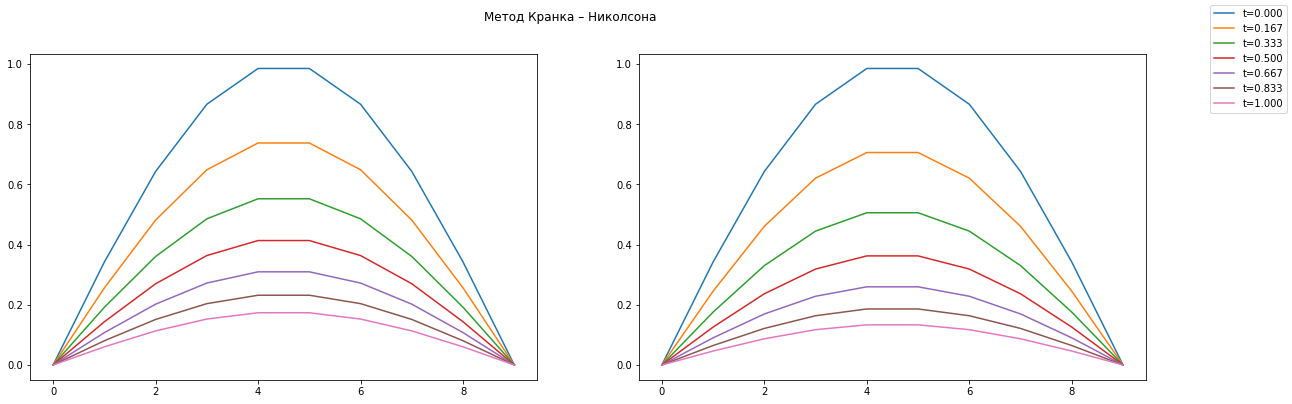

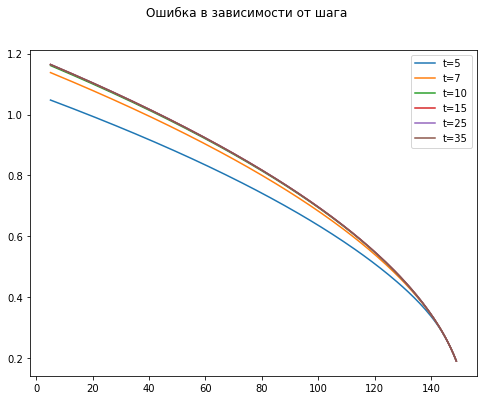

In [15]:
data = CrankNicolson()
data.fit()
data.d()
data.display('Метод Кранка – Николсона')
data.error(np.arange(5,150))